<a href="https://www.kaggle.com/code/mustafakapici/obesity-levels?scriptVersionId=182920797" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Hello buddy, Comments are Welcomed, if you have suggestions & questions ? Please add them in discussion section, happy to have conversion with you, Cheers!

![thanks](https://i.imgflip.com/8ngeel.jpg)

# Import data and package stuff (☞ﾟヮﾟ)☞

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna, warnings, random
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

plt.style.use('dark_background')
warnings.simplefilter('ignore', category=FutureWarning)

In [2]:
path='/kaggle/input/obesity-levels/ObesityDataSet_raw_and_data_sinthetic.csv'

df = pd.read_csv(path)

df

Age  Gender    Height      Weight        CALC FAVC  FCVC  NCP  \
0     21.000000  Female  1.620000   64.000000          no   no   2.0  3.0   
1     21.000000  Female  1.520000   56.000000   Sometimes   no   3.0  3.0   
2     23.000000    Male  1.800000   77.000000  Frequently   no   2.0  3.0   
3     27.000000    Male  1.800000   87.000000  Frequently   no   3.0  3.0   
4     22.000000    Male  1.780000   89.800000   Sometimes   no   2.0  1.0   
...         ...     ...       ...         ...         ...  ...   ...  ...   
2106  20.976842  Female  1.710730  131.408528   Sometimes  yes   3.0  3.0   
2107  21.982942  Female  1.748584  133.742943   Sometimes  yes   3.0  3.0   
2108  22.524036  Female  1.752206  133.689352   Sometimes  yes   3.0  3.0   
2109  24.361936  Female  1.739450  133.346641   Sometimes  yes   3.0  3.0   
2110  23.664709  Female  1.738836  133.472641   Sometimes  yes   3.0  3.0   

      SCC SMOKE      CH2O family_history_with_overweight       FAF       TUE  \
0      no    no  2.000000                            yes  0.000000  1.000000   
1     yes   yes  3.000000                            yes  3.000000  0.000000   
2      no    no  2.000000                            yes  2.000000  1.000000   
3      no    no  2.000000                             no  2.000000  0.000000   
4      no    no  2.000000                             no  0.000000  0.000000   
...   ...   ...       ...                            ...       ...       ...   
2106   no    no  1.728139                            yes  1.676269  0.906247   
2107   no    no  2.005130                            yes  1.341390  0.599270   
2108   no    no  2.054193                            yes  1.414209  0.646288   
2109   no    no  2.852339                            yes  1.139107  0.586035   
2110   no    no  2.863513                            yes  1.026452  0.714137   

           CAEC                 MTRANS           NObeyesdad  
0     Sometimes  Public_Transportation        Normal_Weight  
1     Sometimes  Public_Transportation        Normal_Weight  
2     Sometimes  Public_Transportation        Normal_Weight  
3     Sometimes                Walking   Overweight_Level_I  
4     Sometimes  Public_Transportation  Overweight_Level_II  
...         ...                    ...                  ...  
2106  Sometimes  Public_Transportation     Obesity_Type_III  
2107  Sometimes  Public_Transportation     Obesity_Type_III  
2108  Sometimes  Public_Transportation     Obesity_Type_III  
2109  Sometimes  Public_Transportation     Obesity_Type_III  
2110  Sometimes  Public_Transportation     Obesity_Type_III  

[2111 rows x 17 columns]

In [3]:
#drop unnecessary columns
#df.drop(columns=['unnecessary'], inplace=True)

# Data Insights 🧐

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Gender                          2111 non-null   object 
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   CALC                            2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   SCC                             2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  family_history_with_overweight  2111 non-null   object 
 12  FAF                             21

In [5]:
pd.DataFrame(df.isna().sum()).T.style.background_gradient(cmap='rainbow')

In [6]:
df.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

In [7]:
target = 'NObeyesdad'

cont_cols = df.select_dtypes('number').columns
cont_cols = cont_cols[cont_cols != target]


obj_cols = df.select_dtypes(object).columns
obj_cols = obj_cols[obj_cols != target]


#other_categorics = ['feature1','feature2','feature3','feature4','feature5']

obj_cols = obj_cols.tolist() 


# Convert cont_cols to a list and remove any columns that are in obj_cols
cont_cols = cont_cols.tolist()
cont_cols = [col for col in cont_cols if col not in obj_cols]

len(cont_cols), len(obj_cols)
print(f'Object cols: {obj_cols}')
print(f'Continuous Cols: {cont_cols}')

Object cols: ['Gender', 'CALC', 'FAVC', 'SCC', 'SMOKE', 'family_history_with_overweight', 'CAEC', 'MTRANS']
Continuous Cols: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


In [8]:
def mPlotter(r, c, size, _targets, text):
    
    bg = '#010108'
    
    palette = ['#df5337', '#d24644', '#f7d340', '#3339FF', '#440a68', '#84206b', '#f1ef75', '#fbbe23', '#400a67']
    
    font = 'Comic Sans MS'
    
    fig = plt.figure(figsize=size)
    
    fig.patch.set_facecolor(bg)
    
    grid = fig.add_gridspec(r, c)
    
    grid.update(wspace=0.5, hspace=0.25)
    
    __empty_diff = ((r * c) - 1) - len(_targets)
        
    axes = []
    
    for i in range(r):
        for j in range(c):
            axes.append(fig.add_subplot(grid[i, j]))
    
    for idx, ax in enumerate(axes):
        ax.set_facecolor(bg) 
        
        if idx == 0:
            ax.spines["bottom"].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.5, 0.5,
                 f'{text}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=18, 
                 fontweight='bold',
                 fontfamily=font,
                 color="#fff")
        else:
            if (idx - 1) < len(_targets):
                ax.set_title(_targets[idx - 1].capitalize(), fontsize=14, fontweight='bold', fontfamily=font, color="#fff")
                ax.grid(color='#fff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
                ax.set_xlabel("")
                ax.set_ylabel("")
            else:
                ax.spines["bottom"].set_visible(False)
                ax.tick_params(left=False, bottom=False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
    def cb(ax):
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    if __empty_diff > 0:
        axes = axes[:-1*__empty_diff]
        
    return axes, palette, cb

# Data Visualization 📊

![eda](https://i.imgflip.com/8o7sml.jpg)

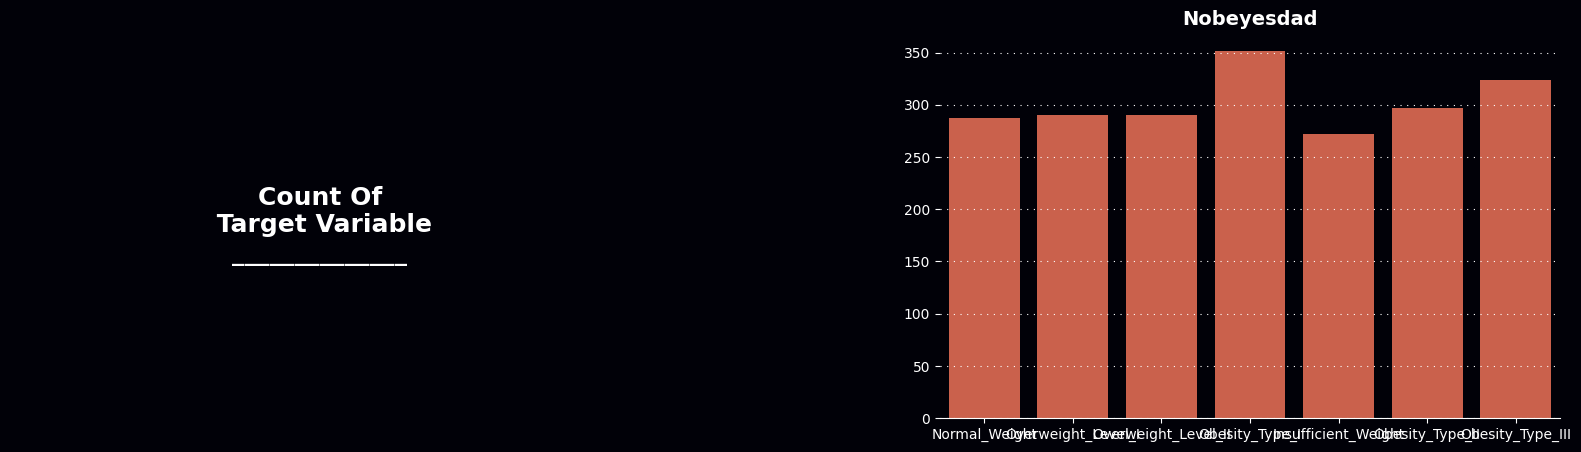

In [9]:
axes, palette, cb = mPlotter(1, 2, (20, 5), [target], 'Count Of\n Target Variable\n______________')

sns.countplot(x=df[target], ax = axes[1], color=palette[0])
cb(axes[1])

/tmp/ipykernel_18/52014056.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[2:9], alpha=.5, linewidth=0, fill=True)
/tmp/ipykernel_18/52014056.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[2:9], alpha=.5, linewidth=0, fill=True)


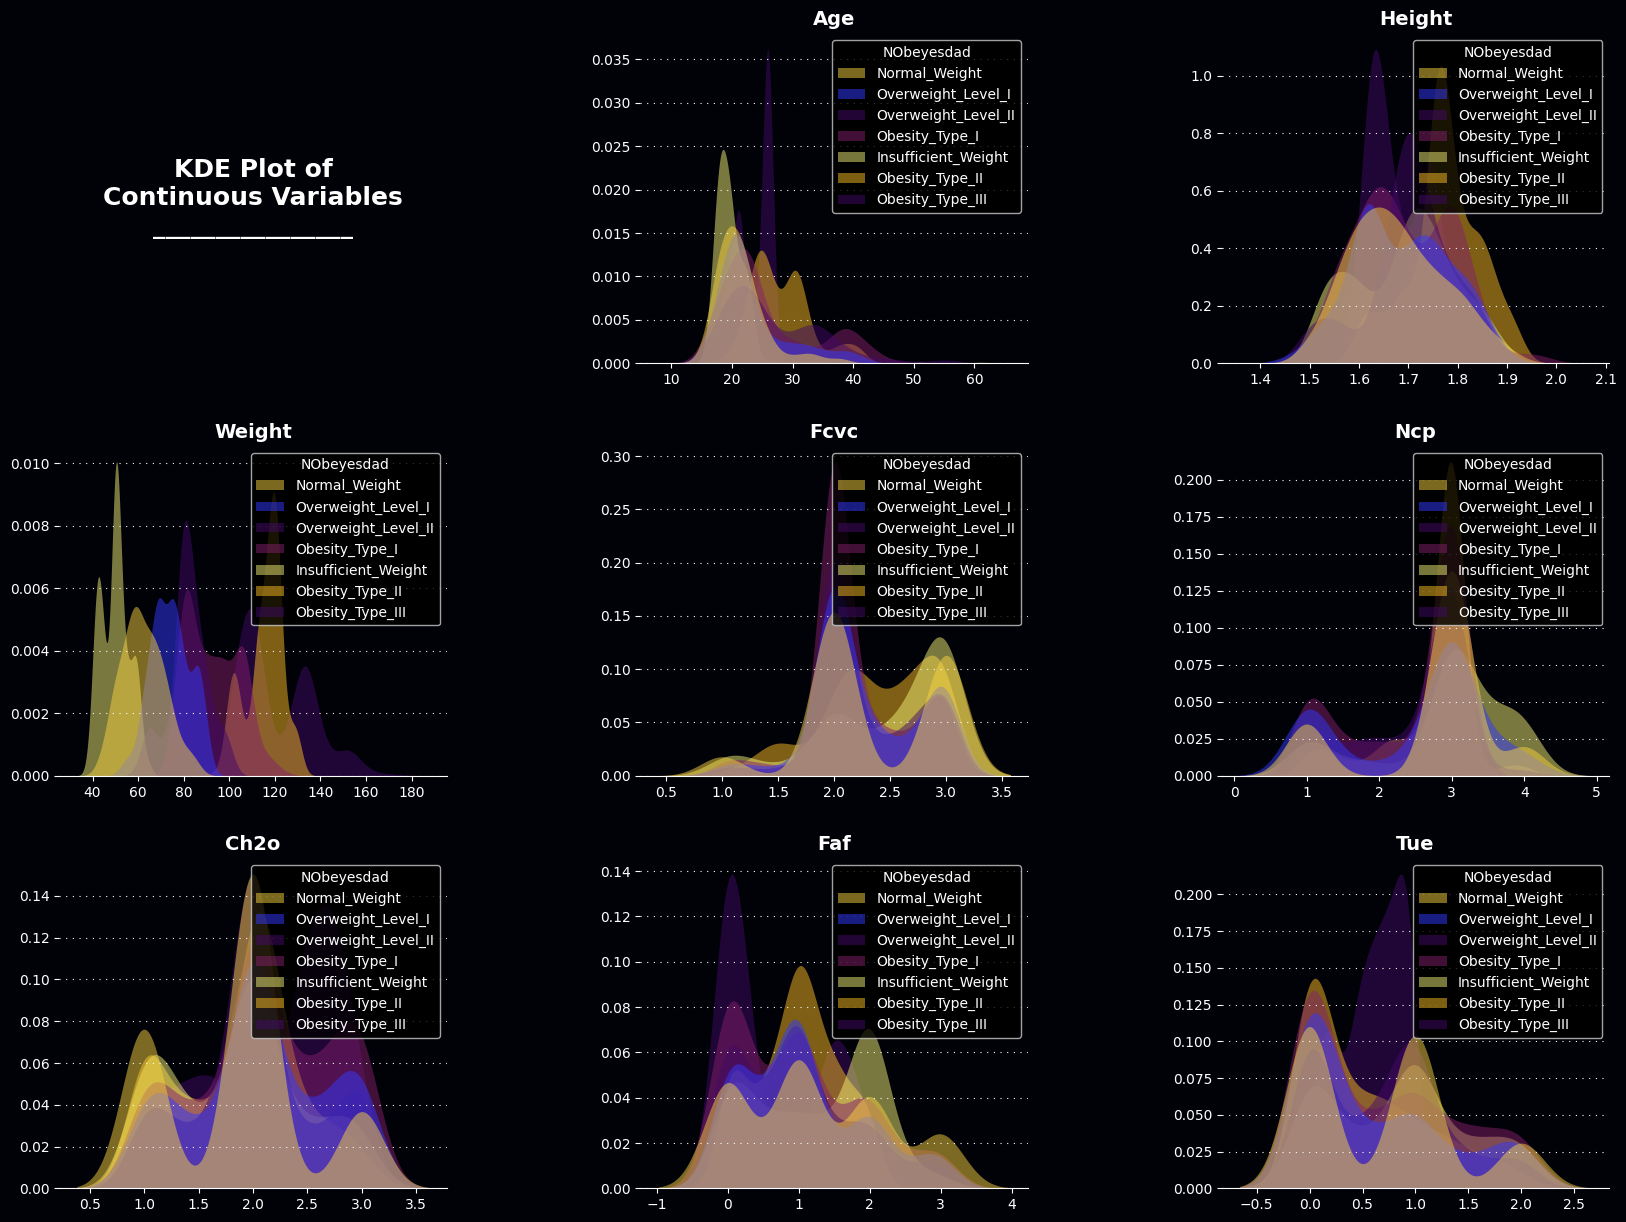

In [10]:
axes, palette, cb = mPlotter(3, 3, (20, 15), cont_cols, 'KDE Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[2:9], alpha=.5, linewidth=0, fill=True)
    cb(ax)

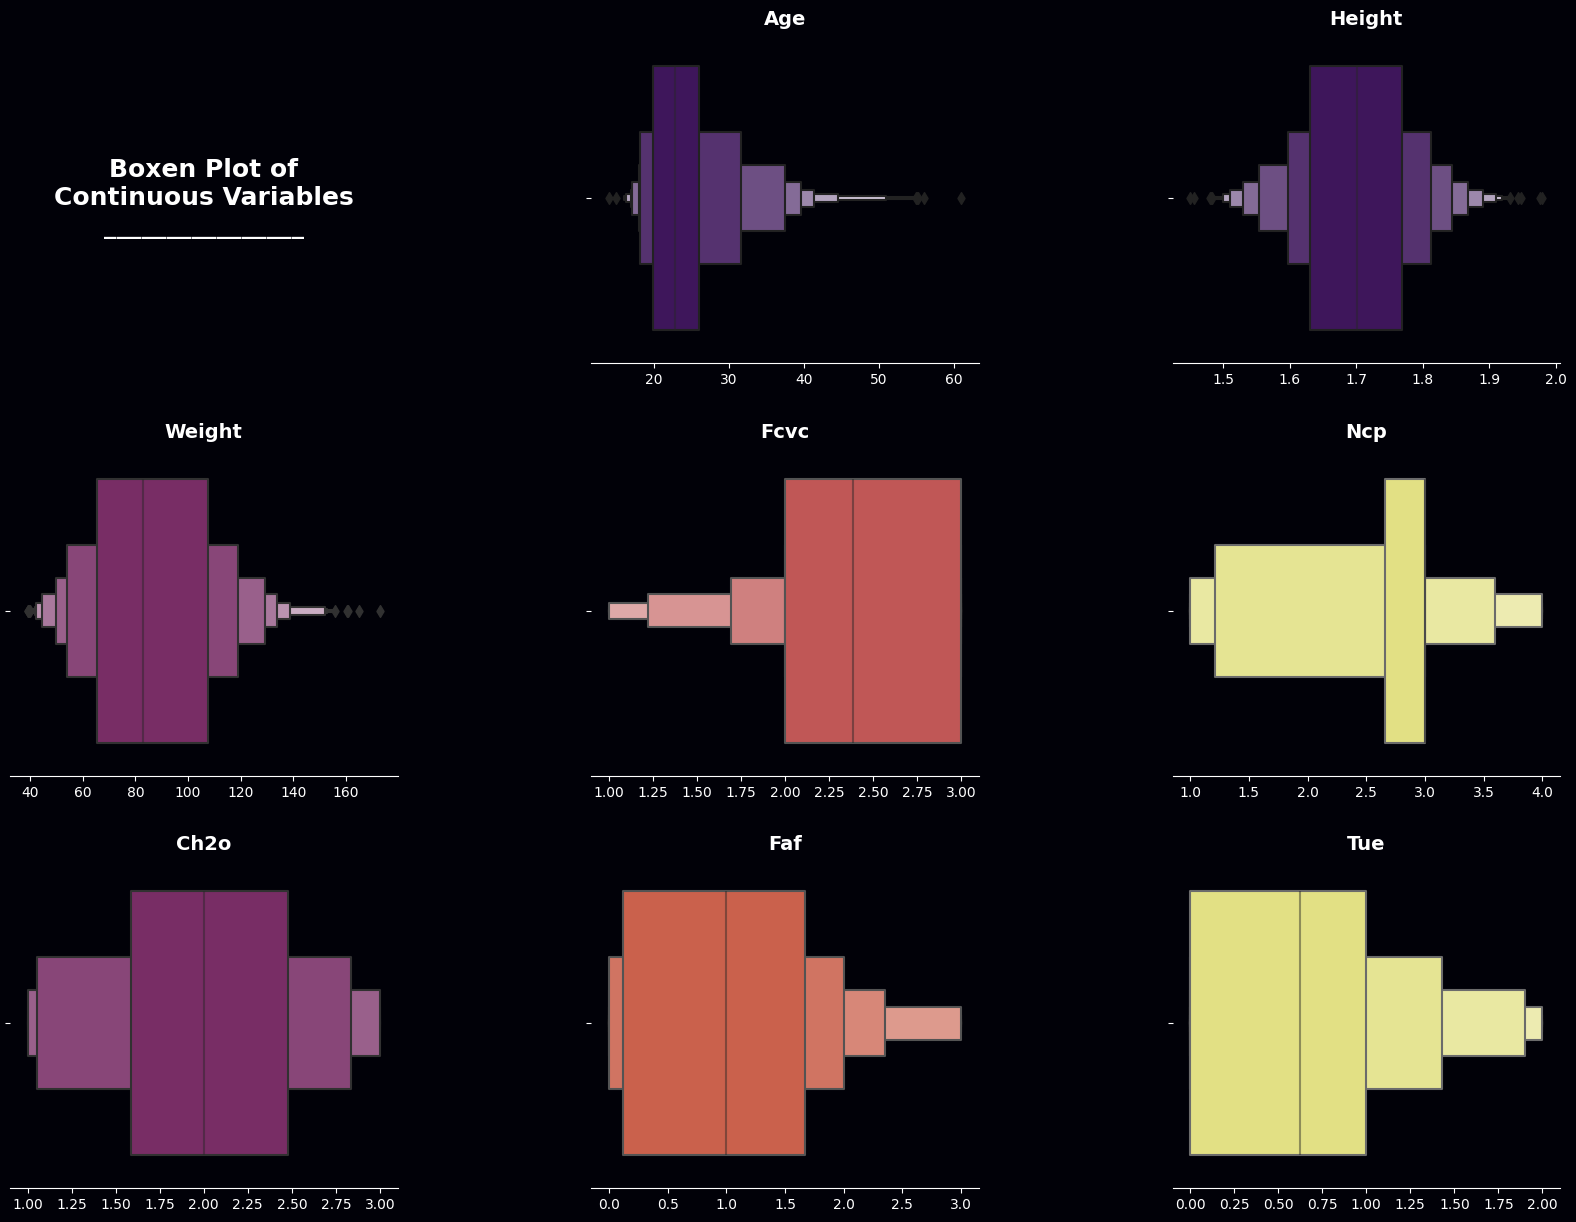

In [11]:
axes, palette, cb = mPlotter(3, 3, (20, 15), cont_cols, 'Boxen Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.boxenplot(data=df, x=col, ax=ax, palette=[palette[random.randint(0, len(palette)-1)]])
    cb(ax)

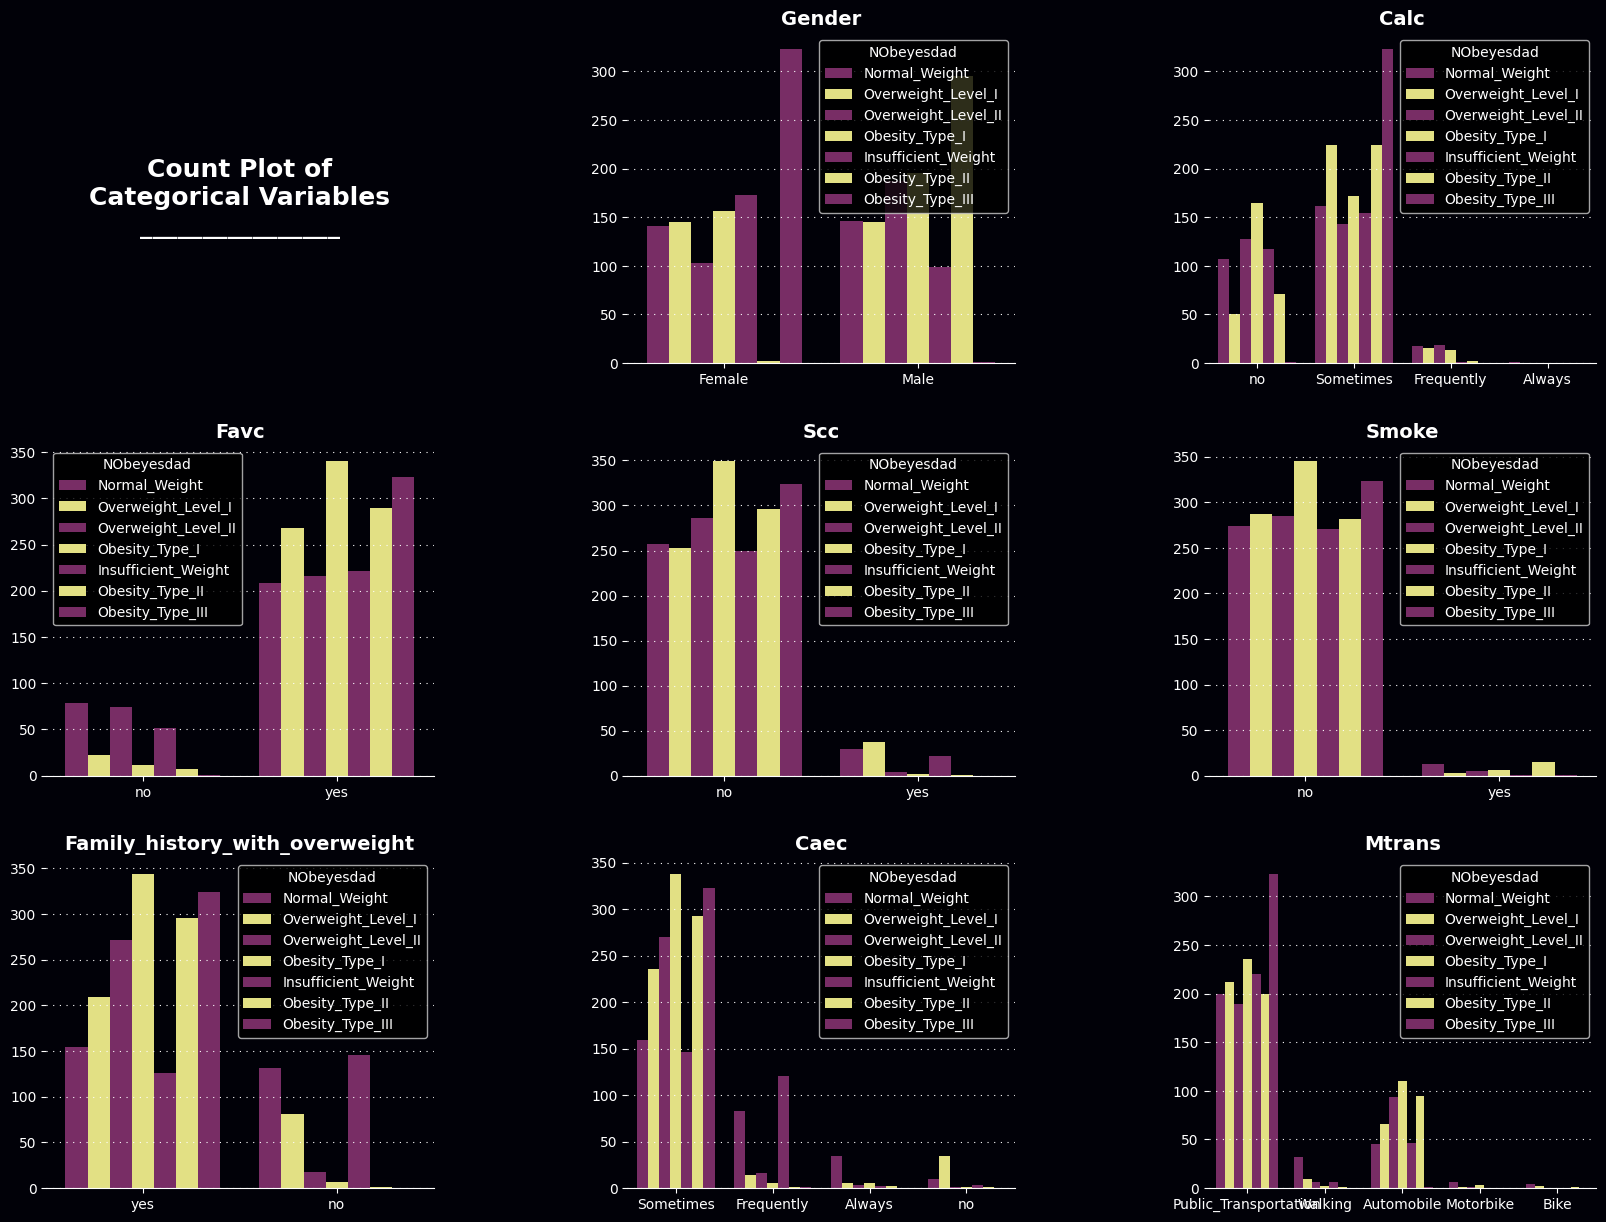

In [12]:
axes, palette, cb = mPlotter(3, 3, (20, 15), obj_cols, 'Count Plot of\nCategorical Variables\n________________')

for col, ax in zip(obj_cols, axes[1:]):
    sns.countplot(data=df, x=col, ax=ax, hue=target, palette=palette[5:7])
    cb(ax)

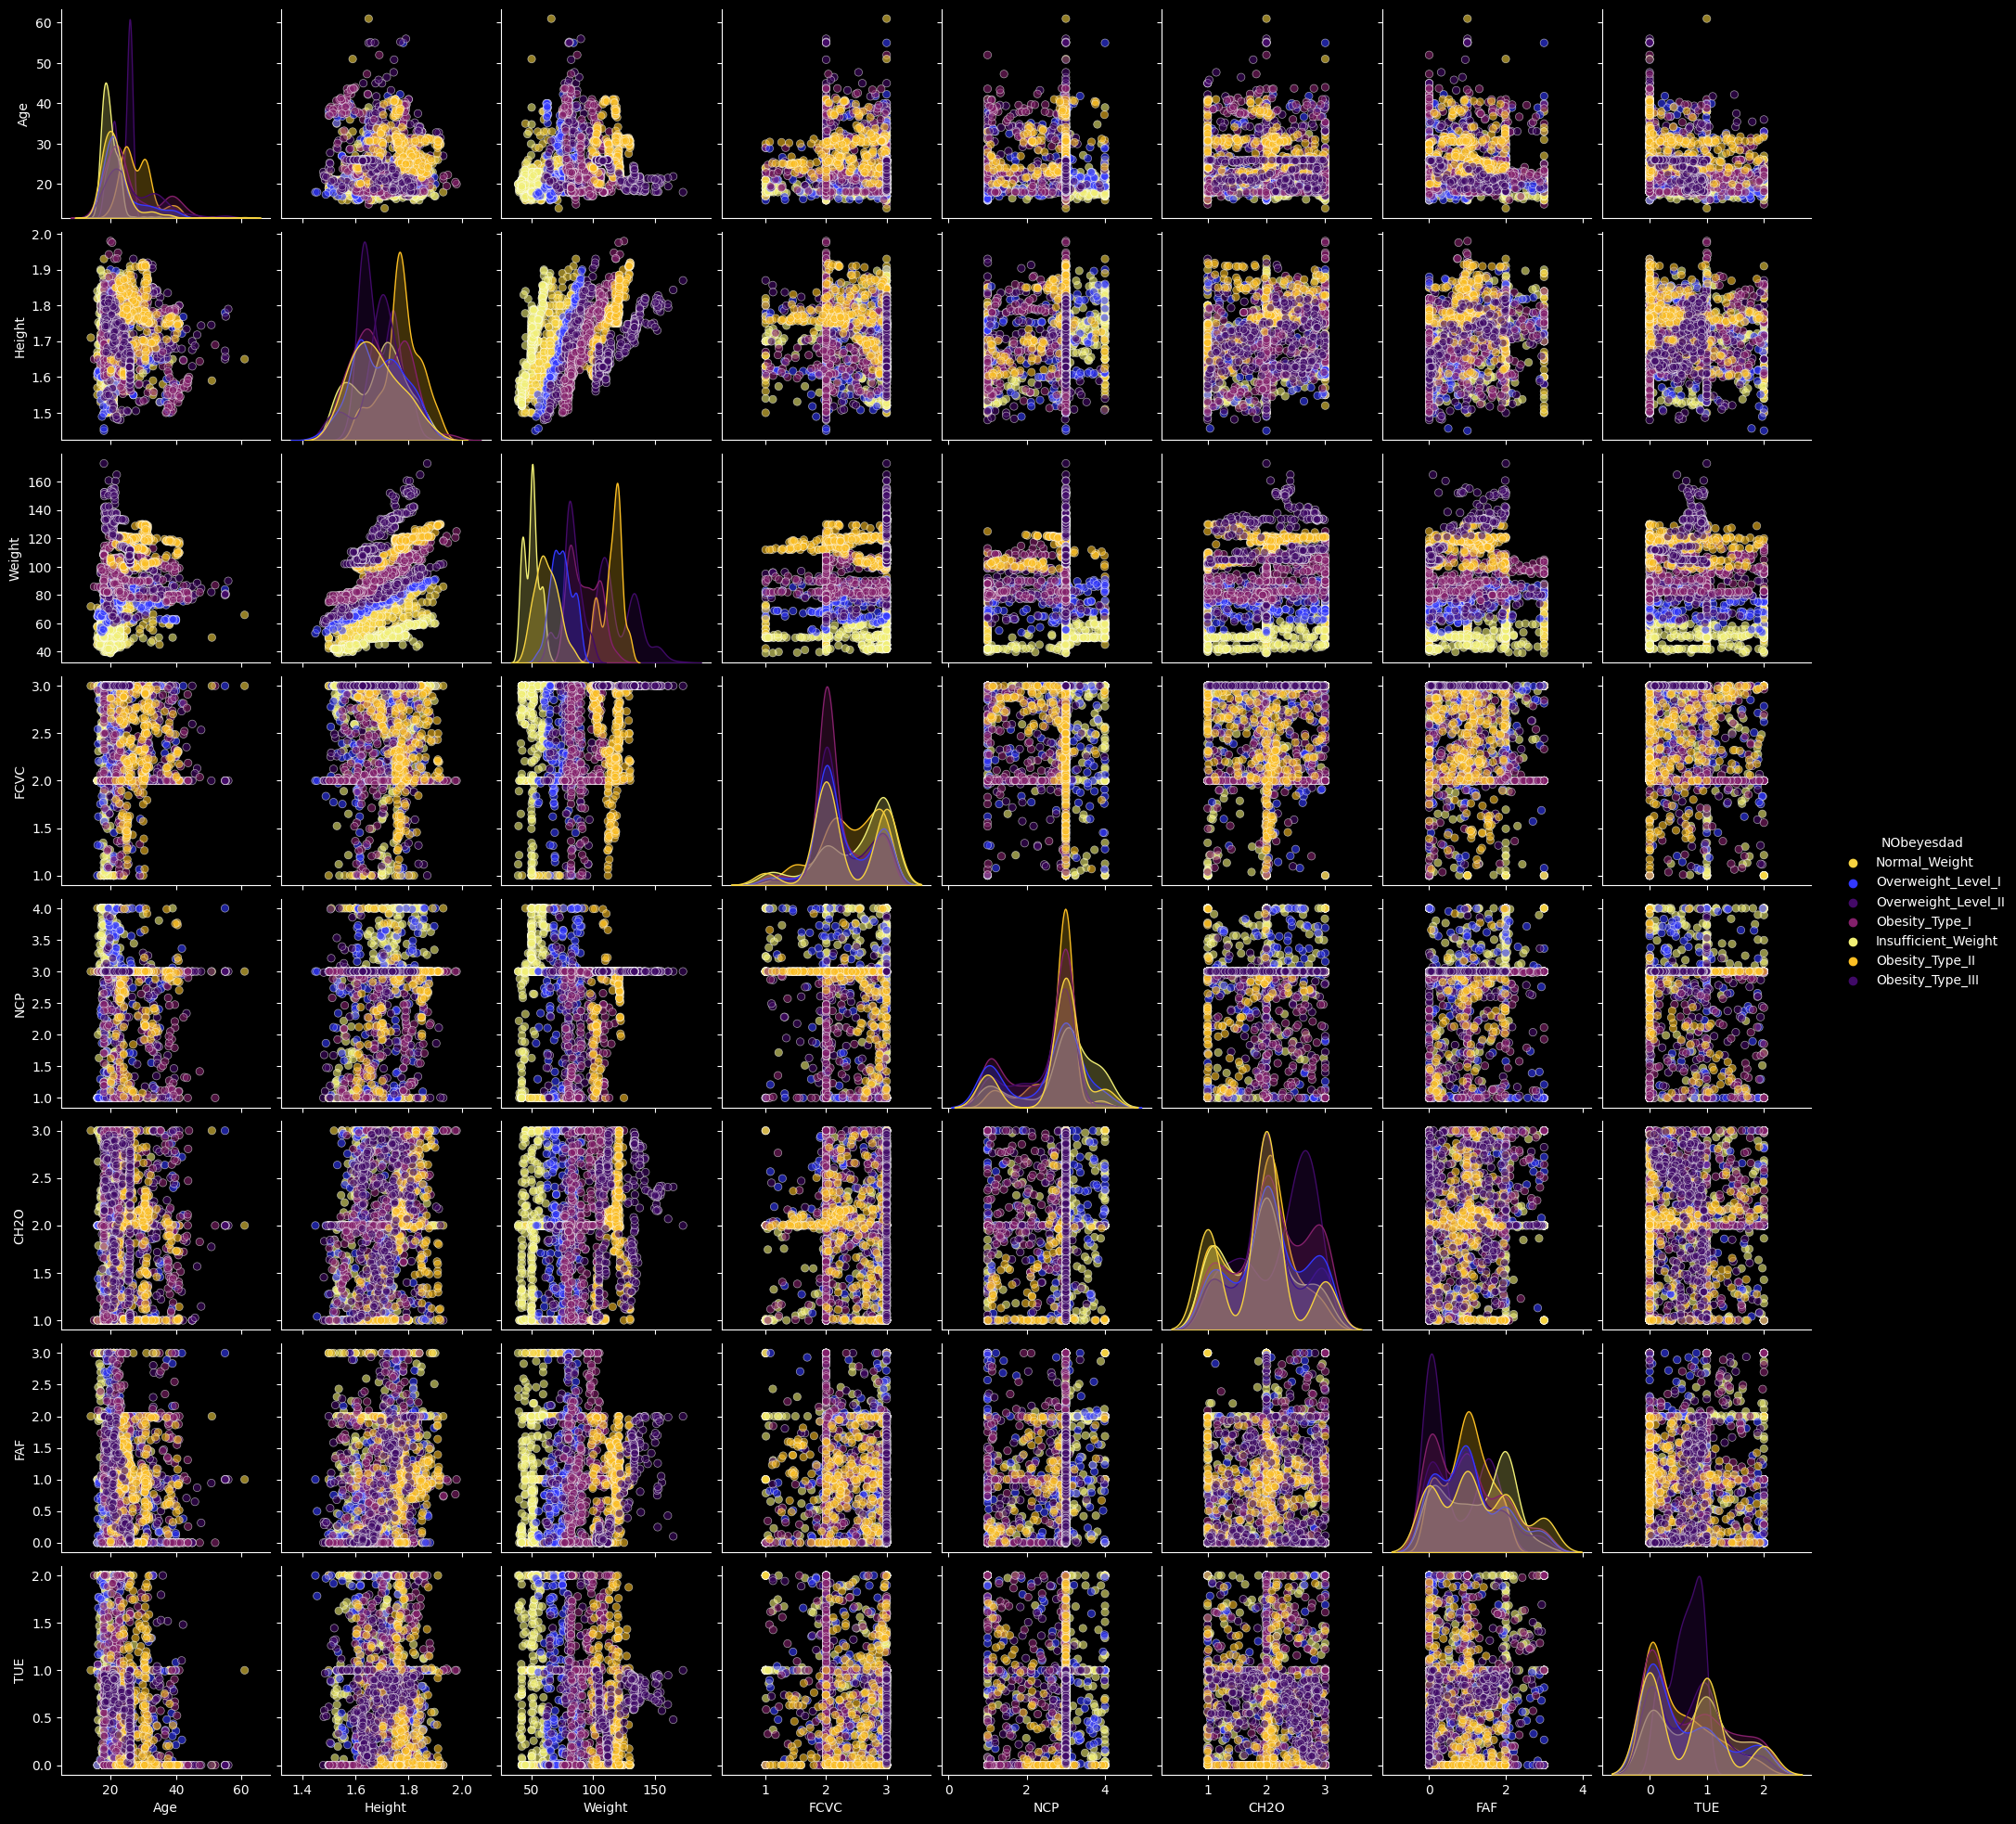

In [13]:
sns.pairplot(data=df, hue=target, palette=palette[2:9], diag_kind='kde', plot_kws={'alpha':.6})

In [14]:
ax = px.scatter_3d(df, x="Age", y="Weight", z="Height", template= "plotly_dark", color=target, title="3D Scatter Plot of Continuous Variables")

ax.show()

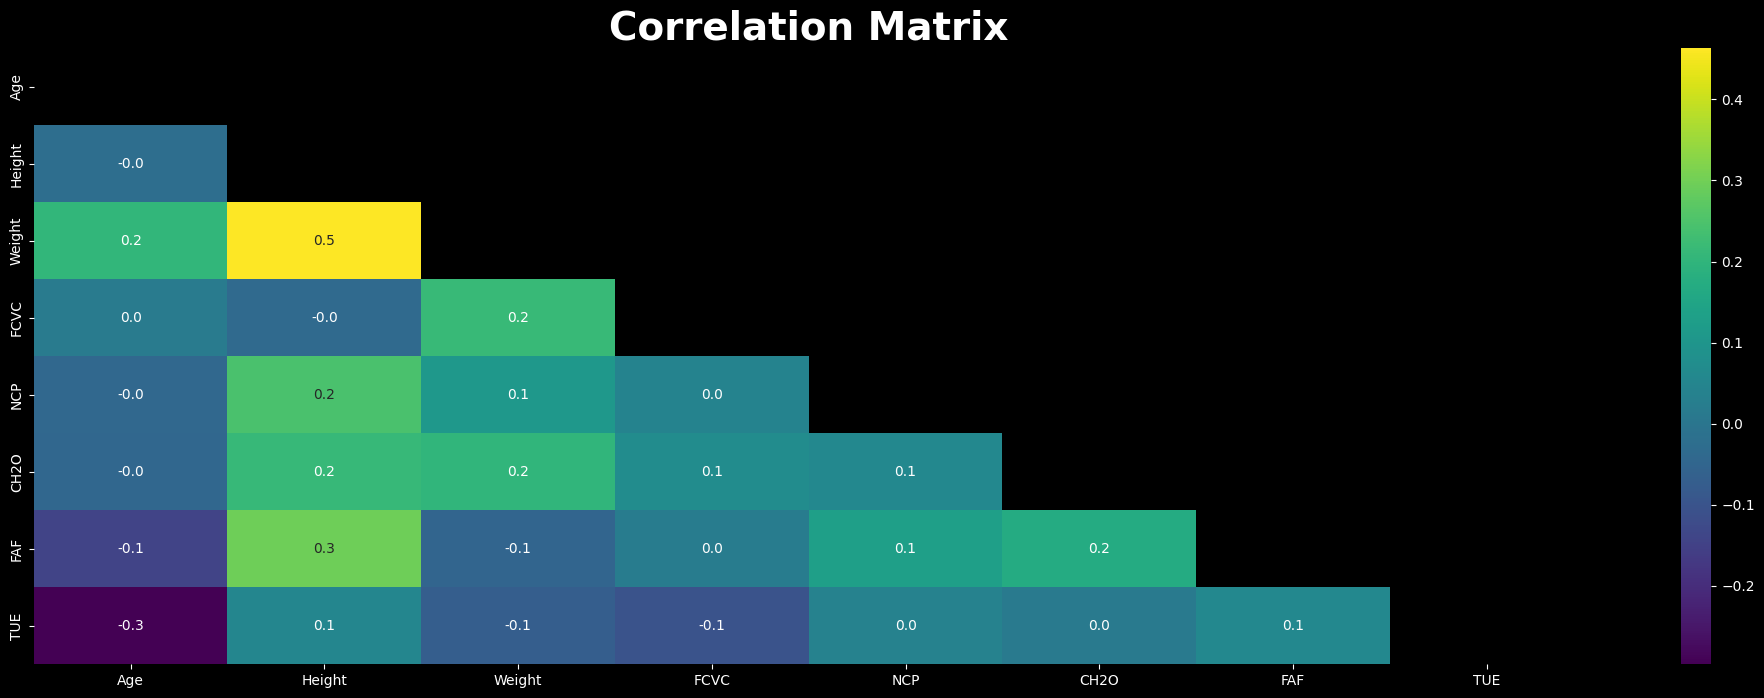

In [15]:
fig = plt.figure(figsize=(25, 8))

gs = fig.add_gridspec(1, 1)

gs.update(wspace=0.3, hspace=0.15)

ax = fig.add_subplot(gs[0, 0])

ax.set_title("Correlation Matrix", fontsize=28, fontweight='bold', fontfamily='Comic Sans MS', color="#fff")

sns.heatmap(df[cont_cols].corr().transpose(), mask=np.triu(np.ones_like(df[cont_cols].corr().transpose())), fmt=".1f", annot=True, cmap='viridis')

plt.show()

In [16]:
for col in df.select_dtypes(object):
    df[col] = LabelEncoder().fit_transform(df[col])
    
df

Age  Gender    Height      Weight  CALC  FAVC  FCVC  NCP  SCC  \
0     21.000000       0  1.620000   64.000000     3     0   2.0  3.0    0   
1     21.000000       0  1.520000   56.000000     2     0   3.0  3.0    1   
2     23.000000       1  1.800000   77.000000     1     0   2.0  3.0    0   
3     27.000000       1  1.800000   87.000000     1     0   3.0  3.0    0   
4     22.000000       1  1.780000   89.800000     2     0   2.0  1.0    0   
...         ...     ...       ...         ...   ...   ...   ...  ...  ...   
2106  20.976842       0  1.710730  131.408528     2     1   3.0  3.0    0   
2107  21.982942       0  1.748584  133.742943     2     1   3.0  3.0    0   
2108  22.524036       0  1.752206  133.689352     2     1   3.0  3.0    0   
2109  24.361936       0  1.739450  133.346641     2     1   3.0  3.0    0   
2110  23.664709       0  1.738836  133.472641     2     1   3.0  3.0    0   

      SMOKE      CH2O  family_history_with_overweight       FAF       TUE  \
0         0  2.000000                               1  0.000000  1.000000   
1         1  3.000000                               1  3.000000  0.000000   
2         0  2.000000                               1  2.000000  1.000000   
3         0  2.000000                               0  2.000000  0.000000   
4         0  2.000000                               0  0.000000  0.000000   
...     ...       ...                             ...       ...       ...   
2106      0  1.728139                               1  1.676269  0.906247   
2107      0  2.005130                               1  1.341390  0.599270   
2108      0  2.054193                               1  1.414209  0.646288   
2109      0  2.852339                               1  1.139107  0.586035   
2110      0  2.863513                               1  1.026452  0.714137   

      CAEC  MTRANS  NObeyesdad  
0        2       3           1  
1        2       3           1  
2        2       3           1  
3        2       4           5  
4        2       3           6  
...    ...     ...         ...  
2106     2       3           4  
2107     2       3           4  
2108     2       3           4  
2109     2       3           4  
2110     2       3           4  

[2111 rows x 17 columns]

# Split the cakes equal 🍰

In [17]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target])


In [18]:
X = df.drop(columns=[target], axis=1)
y = df[target].values

In [19]:
X.head()

Age  Gender  Height  Weight  CALC  FAVC  FCVC  NCP  SCC  SMOKE  CH2O  \
0  21.0       0    1.62    64.0     3     0   2.0  3.0    0      0   2.0   
1  21.0       0    1.52    56.0     2     0   3.0  3.0    1      1   3.0   
2  23.0       1    1.80    77.0     1     0   2.0  3.0    0      0   2.0   
3  27.0       1    1.80    87.0     1     0   3.0  3.0    0      0   2.0   
4  22.0       1    1.78    89.8     2     0   2.0  1.0    0      0   2.0   

   family_history_with_overweight  FAF  TUE  CAEC  MTRANS  
0                               1  0.0  1.0     2       3  
1                               1  3.0  0.0     2       3  
2                               1  2.0  1.0     2       3  
3                               0  2.0  0.0     2       4  
4                               0  0.0  0.0     2       3

In [20]:
y

array([1, 1, 1, ..., 4, 4, 4])

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1477, 16), (634, 16), (1477,), (634,))

# Scale the data to ground 🌄

In [22]:
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

# The Black Magic 🧿

![model](https://i.imgflip.com/8o7ssy.jpg)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    #'XGBoost': XGBClassifier(),
    #'CatBoost': CatBoostClassifier(verbose=0),
    'KNN': KNeighborsClassifier(),
    #'Neural Network': MLPClassifier(),
    #'LGBM': LGBMClassifier(),
    'Voting Classifier': VotingClassifier(
        estimators=[
            ('cat', CatBoostClassifier(verbose=0)), 
            ('xg', XGBClassifier()), 
            ('lgbm', LGBMClassifier(verbose=-1))],
    voting='soft',
    verbose=False
)
}


params={
    'Logistic Regression': {'C': [0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [200]},
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'Random Forest': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'KNN': {'n_neighbors': [3, 5, 7, 9 , 13], 'weights': ['uniform', 'distance']},
    'Naive Bayes': { 'var_smoothing': [1e-9, 1e-8, 1e-7]},
    'Neural Network': {'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)], 
                       'activation': ['logistic', 'tanh', 'relu'],
                       'solver': ['adam'], 'alpha': [0.0001, 0.001, 0.01],
                       'max_iter': [ 500, 1000,2000]},
    'XGBoost': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'LGBM': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'CatBoost': {'iterations': [100, 300, 500], 'depth': [3, 5, 7, 9, 11, 13]},
    'Voting Classifier': {}
}

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score , f1_score ,classification_report

# Train function
def train_model(X_train, y_train, models, params):
    best_estimators = {}
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=params[model_name],
            scoring='accuracy',
            cv=5, n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        best_estimators[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best score for {model_name}: {grid_search.best_score_}\n")
    return best_estimators

# Evaluate function
def evaluate_model(X_test, y_test, models):
    classification_reports = {}

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

       

        classification_rep = classification_report(y_test, y_pred)

       

        classification_reports[model_name] = classification_rep

    return  classification_reports

In [25]:
# Train the models
best_models = train_model(X_train, y_train, models, params)

Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 100, 'max_iter': 200, 'solver': 'liblinear'}
Best score for Logistic Regression: 0.760306917086578

Training Decision Tree...
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 11}
Best score for Decision Tree: 0.9485409986257445

Training Random Forest...
Best parameters for Random Forest: {'max_depth': 13, 'n_estimators': 300}
Best score for Random Forest: 0.9559963353183691

Training Naive Bayes...
Best parameters for Naive Bayes: {'var_smoothing': 1e-07}
Best score for Naive Bayes: 0.5822102611085661

Training KNN...
Best parameters for KNN: {'n_neighbors': 3, 'weights': 'distance'}
Best score for KNN: 0.7901122308749426

Training Voting Classifier...
Best parameters for Voting Classifier: {}
Best score for Voting Classifier: 0.969532753092075



In [26]:
# Evaluate the best models
classification_reports = evaluate_model(X_test, y_test, best_models)

Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Naive Bayes...
Evaluating KNN...
Evaluating Voting Classifier...


# Oversee the model performance 👀

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Print classification reports
for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88        86
           1       0.79      0.35      0.49        93
           2       0.73      0.36      0.48       102
           3       0.94      0.94      0.94        88
           4       1.00      0.99      0.99        98
           5       0.49      0.62      0.55        88
           6       0.41      0.71      0.52        79

    accuracy                           0.70       634
   macro avg       0.74      0.71      0.69       634
weighted avg       0.74      0.70      0.69       634


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        86
           1       0.45      0.72      0.56        93
           2       0.68      0.48      0.56       102
           3       0.92      0.78      0.85        88
           4       1.00      0.93      0.9

![thanksagain](https://i.imgflip.com/8ou6ip.jpg)

![thanksagain](https://i.imgflip.com/8o7tp4.jpg)

#  Any suggestion to improve performance are welcomed.